Денис Иванов

###  Домашнее задание

### Временные ряды: ARIMA и GARCH

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import  RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import model_selection
from sklearn.model_selection import train_test_split, 

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor

from warnings import filterwarnings 
filterwarnings('ignore')

from arch import arch_model

### Выберите ряд и постройте его модель ARIMA/GARCH.


Временной ряд колебаний индекса Доу Джонса в 1971 - 1973 году

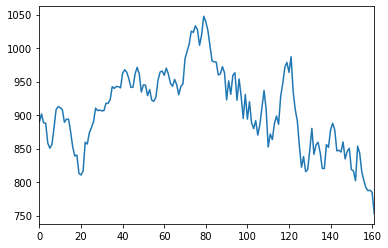

In [2]:
dj   = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
p_series = dj.Close
p_series.plot()

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y       = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout  = (5, 1)
        ts_ax   = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax  = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax   = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Проверим ряд на стационарность, применим тест Дики Фуллера

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


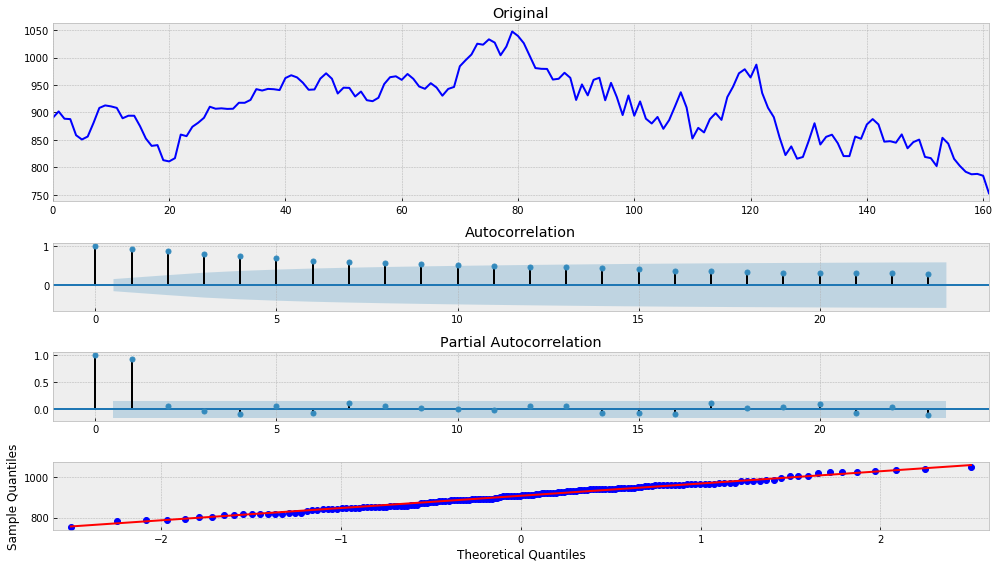

In [6]:
tsplot(p_series)

Ряд очевидно нестационарен, цикличность и сезоннность неочевидна. Формально можно предположить, что цикличность выходит за рамки периода наблюдений ... но историческими данными это не подтверждается.  Автокорреляция "в лоб" тоже очевидных результатов не дает.

Пробуем применить преобразование Бокса - Кокса  для выравнивания дисперсии

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


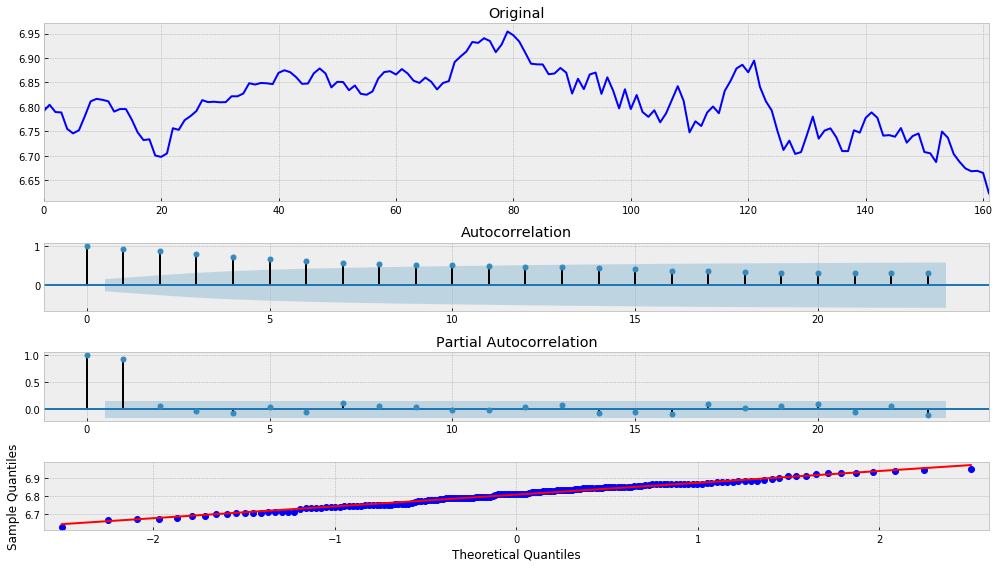

In [7]:
p_series_bcox = boxcox(p_series,0)
tsplot(p_series_bcox)

Преобразование Бокса - Кокса не прибавляет стационарности ряда, p value только вырос, показатель ухудшился

Применим дифференцирование ряда и рассмотрим как значение коэффициента дифференцирования повлияет на стационарность ряда

In [8]:
pval_opt = pd.DataFrame(columns = ['koef', 'pvalue', 'pvalue_bcox'])

for i in range (25):
    pval_opt.loc[i] = [i, 
                       adfuller(difference(p_series, i), autolag='AIC')[1],
                       adfuller(difference(p_series_bcox, i), autolag='AIC')[1]]

pval_opt.sort_values(by=['pvalue']).head(8)

,koef,pvalue,pvalue_bcox
1,1.0,2.407586e-24,2.751609e-24
2,2.0,4.436788e-05,6.926378e-05
4,4.0,4.116433e-03,4.059682e-03
5,5.0,4.572820e-03,6.032016e-03
3,3.0,8.289719e-03,1.006453e-02
17,17.0,1.064801e-02,9.706626e-02
9,9.0,2.186101e-02,2.341628e-02
8,8.0,5.407870e-02,1.188826e-02


Еще раз подтверждаем, что в данном конкретном случае преобразование Бокса Кокса неуместно

Коэффициент дифференцирования № 1 = 1

In [9]:
p_series_1 = difference(p_series, 1)

pval_opt = pd.DataFrame(columns = ['koef', 'pvalue'])

for i in range (25):
    pval_opt.loc[i] = [i, 
                       adfuller(difference(p_series_1, i), autolag='AIC')[1]]

pval_opt.sort_values(by=['pvalue']).head(8)

,koef,pvalue
23,23.0,4.565205e-23
18,18.0,4.832714e-22
17,17.0,7.216775e-20
20,20.0,4.307724e-19
10,10.0,2.968646e-11
4,4.0,4.901330e-11
9,9.0,4.991229e-11
8,8.0,6.721349e-11


Видим, что всякое последующее дифференцирование этого ряда ведет к повышению  / ухудшению уровня p value,  что обосновывает отсутствие необходимости повторного дифференцирования

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


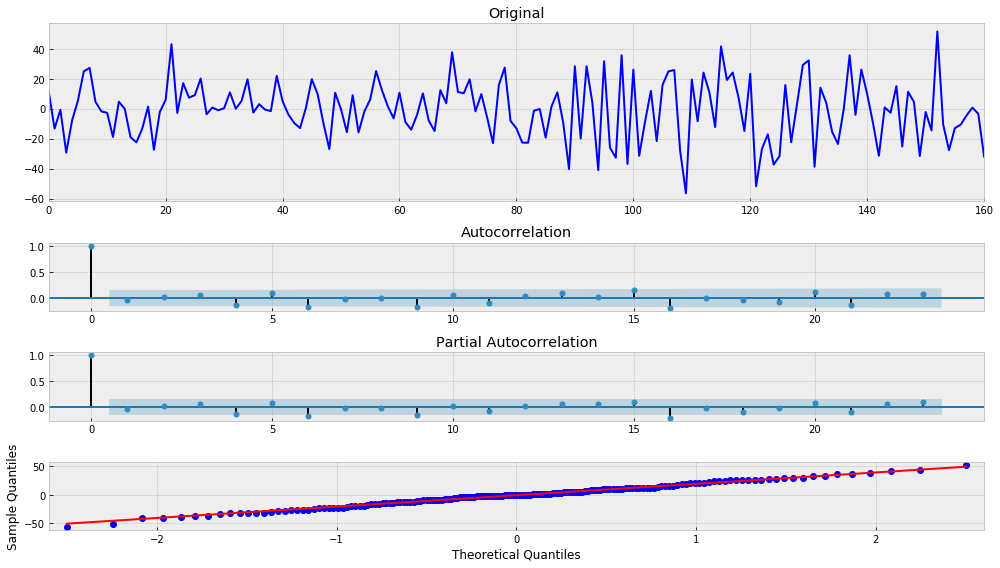

In [10]:
tsplot(p_series_1)

In [11]:
train, val = p_series_1[:120], p_series_1[120:]

In [18]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):         
        for d in range(5):     
            for j in range(5): 
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, best_mdl = _get_best_model(p_series_1)

aic: 1416.27670 | order: (2, 1, 3)


Results of Dickey-Fuller Test:
Test Statistic                -1.184571e+01
p-value                        7.408179e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


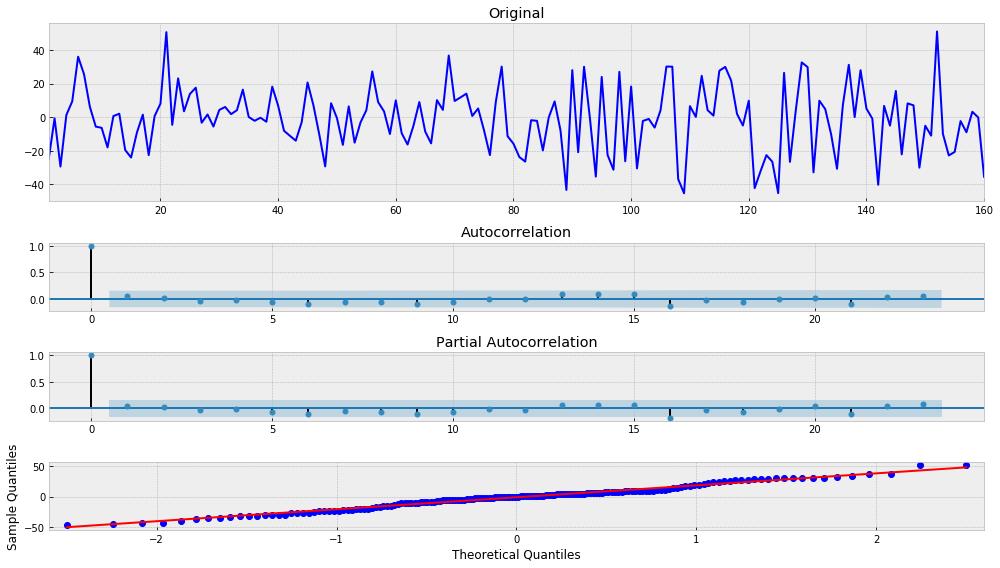

In [20]:
tsplot(best_mdl.resid)

Ряд близок к стационарному.  

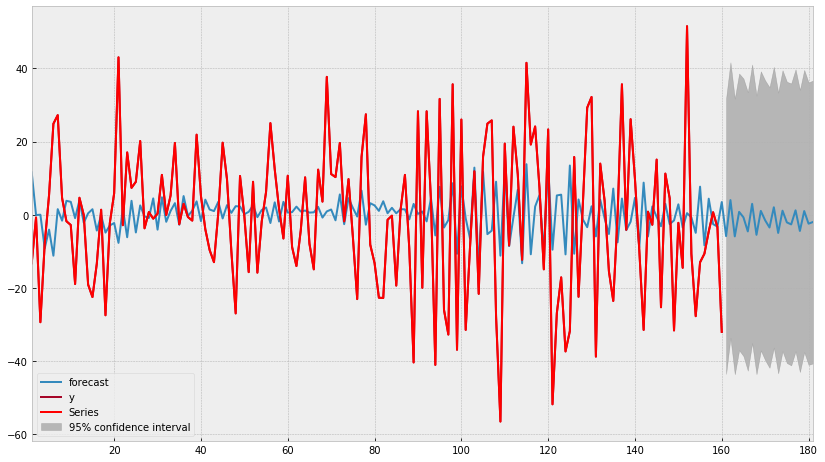

In [160]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(p_series_1)+20, ax=ax)
    plt.plot(p_series_1, color='red', label='Series')
    plt.legend()
    plt.show()

In [161]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 2
o_ = 0
q_ = 3

# Using student T distribution usually provides better fit
am =  arch_model(p_series_1, p=p_, o=o_, q=q_, dist='StudentsT') 
res = am.fit(update_freq=5, disp='off')
print(res.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.004
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                            GARCH   Log-Likelihood:               -701.661
Distribution:      Standardized Student's t   AIC:                           1419.32
Method:                  Maximum Likelihood   BIC:                           1443.97
                                              No. Observations:                  161
Date:                      Wed, Dec 09 2020   Df Residuals:                      153
Time:                              20:26:05   Df Model:                            8
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


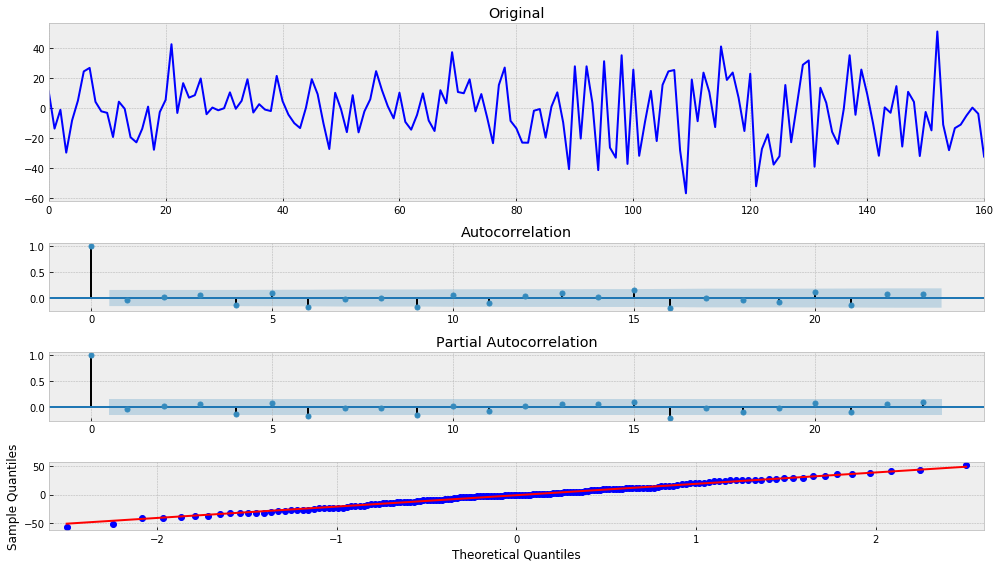

In [162]:
tsplot(res.resid)

## Прогноз временного ряда с помощью классических инструментов  ML

Вариант 1

Предсказание осуществляется в отношении дифференцированного ряда (p_series_!).

Train - Test split - модель обучается на Train  выборке,  прогноз на Test  выборке.

Модель - стек с рергессий с разной логикой предсказаний (из коробки)

В качестве признаков значения возьмем 20 предшествующих  значений временнного ряда, и построим традиционный датафрейм признаков

In [163]:
d_s = pd.concat([p_series_1, pd.DataFrame(np.full([161, 20], 0))],axis =1) #p_series_1
d_s
for i in range(20,161):
    d_s.iloc[i,1:] = p_series_1.tolist()[(i-20):i]

In [164]:
d_s         =  d_s[20:]
d_s.columns = ['Close'] + list(range(-20,0,1))
d_s = d_s.reset_index()
d_s.tail()

,index,Close,-20,-19,-18,-17,-16,-15,-14,-13,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
136,156,-10.64,-0.08,35.67,-4.07,26.13,9.78,-9.70,-31.45,0.86,...,-25.26,11.26,4.54,-31.60,-2.19,-14.48,51.55,-10.63,-27.70,-12.98
137,157,-4.54,35.67,-4.07,26.13,9.78,-9.70,-31.45,0.86,-2.73,...,11.26,4.54,-31.60,-2.19,-14.48,51.55,-10.63,-27.70,-12.98,-10.64
138,158,0.71,-4.07,26.13,9.78,-9.70,-31.45,0.86,-2.73,15.09,...,4.54,-31.60,-2.19,-14.48,51.55,-10.63,-27.70,-12.98,-10.64,-4.54
139,159,-3.37,26.13,9.78,-9.70,-31.45,0.86,-2.73,15.09,-25.26,...,-31.60,-2.19,-14.48,51.55,-10.63,-27.70,-12.98,-10.64,-4.54,0.71
140,160,-31.99,9.78,-9.70,-31.45,0.86,-2.73,15.09,-25.26,11.26,...,-2.19,-14.48,51.55,-10.63,-27.70,-12.98,-10.64,-4.54,0.71,-3.37


In [262]:
x  = d_s.iloc[:,2:]
Y  = d_s.iloc[:,1]

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 1000)

In [263]:
estimators = [
              ('lasso',  LassoCV()),     
              ('knr',    KNeighborsRegressor(n_neighbors = 8)),
              ('ridge',  RidgeCV()),
              ('rfr',    RandomForestRegressor()),
              ('abr',    AdaBoostRegressor())
            ]

In [264]:
reg = StackingRegressor(
                        estimators=estimators,
                        final_estimator=GradientBoostingRegressor(random_state=100))

In [265]:
reg.fit(x_train, y_train)

StackingRegressor(estimators=[('lasso', LassoCV()),
                              ('knr', KNeighborsRegressor(n_neighbors=8)),
                              ('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('rfr', RandomForestRegressor()),
                              ('abr', AdaBoostRegressor())],
                  final_estimator=GradientBoostingRegressor(random_state=100))

In [266]:
reg.final_estimator_.feature_importances_

array([0.19464153, 0.20646364, 0.19092068, 0.19221877, 0.21575538])

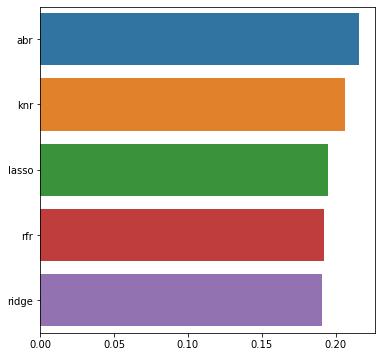

In [267]:
headers = list(reg.named_estimators_.keys())
feature_imp = pd.Series(reg.final_estimator_.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

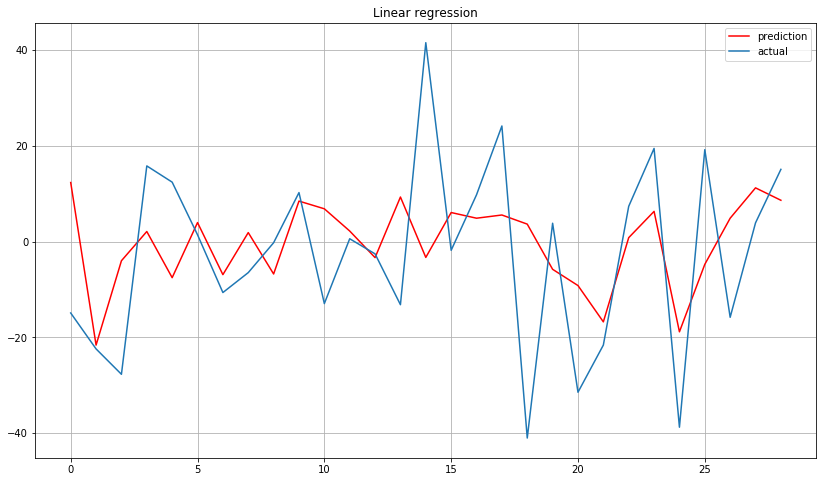

In [268]:
plt.figure(figsize=(14, 8))
plt.plot(reg.predict(x_test), "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

In [269]:
mean_squared_error(reg.predict(x_test), y_test.values )

333.9617528596576

Вариант 2

Предсказание осуществляется в отношении исходного ряда (p_series).

В качестве признаков значения- 20 предшествующих значений временнного ряда (аналогично модели 1)

Модель обучается на полной выборке, прогноз  строится по следующей схеме:
- первая точка прогноза исходя из последних значений исходного ряда:
- со второй точки  - исходя из вновь предсказанных значений и оставшихся значений временного ряда 

Модель - стек с рергессий с разной логикой предсказаний (из коробки)

In [270]:
d_s_2 = pd.concat([p_series, pd.DataFrame(np.full([162, 20], 0))],axis =1)

for i in range(20,162):
    d_s_2.iloc[i,1:] = p_series.tolist()[(i-20):i]

In [271]:
d_s_2         =  d_s_2[20:]
d_s_2.columns = ['Close'] + list(range(-20,0,1))
d_s_2         = d_s_2.reset_index().iloc[:,1:]
d_s_2.tail()

,Close,-20,-19,-18,-17,-16,-15,-14,-13,-12,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
137,791.77,820.32,855.99,851.92,878.05,887.83,878.13,846.68,847.54,844.81,...,834.64,845.90,850.44,818.84,816.65,802.17,853.72,843.09,815.39,802.41
138,787.23,855.99,851.92,878.05,887.83,878.13,846.68,847.54,844.81,859.90,...,845.90,850.44,818.84,816.65,802.17,853.72,843.09,815.39,802.41,791.77
139,787.94,851.92,878.05,887.83,878.13,846.68,847.54,844.81,859.90,834.64,...,850.44,818.84,816.65,802.17,853.72,843.09,815.39,802.41,791.77,787.23
140,784.57,878.05,887.83,878.13,846.68,847.54,844.81,859.90,834.64,845.90,...,818.84,816.65,802.17,853.72,843.09,815.39,802.41,791.77,787.23,787.94
141,752.58,887.83,878.13,846.68,847.54,844.81,859.90,834.64,845.90,850.44,...,816.65,802.17,853.72,843.09,815.39,802.41,791.77,787.23,787.94,784.57


In [272]:
x  = d_s_2.iloc[:,1:]
Y  = d_s_2.iloc[:,0]

In [298]:
estimators = [
              ('lasso',  LassoCV()),              
              ('knr',    KNeighborsRegressor()),
              ('ridge',  RidgeCV()),
              ('rfr',    RandomForestRegressor()),
              ('abr',    AdaBoostRegressor())
            ]
reg       = StackingRegressor(
               estimators=estimators,
               final_estimator=GradientBoostingRegressor(random_state=1000))

In [299]:
reg.fit(x, Y)

StackingRegressor(estimators=[('lasso', LassoCV()),
                              ('knr', KNeighborsRegressor()),
                              ('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('rfr', RandomForestRegressor()),
                              ('abr', AdaBoostRegressor())],
                  final_estimator=GradientBoostingRegressor(random_state=1000))

In [300]:
reg.final_estimator_.feature_importances_

array([0.58719026, 0.02325617, 0.34091646, 0.01503103, 0.03360608])

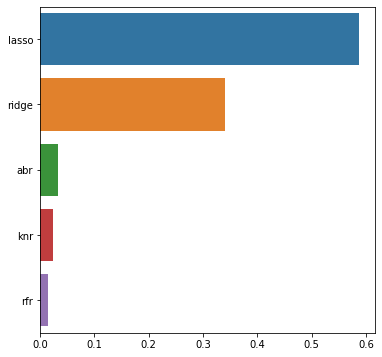

In [301]:
headers = list(reg.named_estimators_.keys())
feature_imp = pd.Series(reg.final_estimator_.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

In [302]:
mean_squared_error(Y, reg.predict(x))

471.69057013196044

In [303]:
p1 = []
for i in headers:
    p1.append(mean_squared_error(y_test, reg.named_estimators_[i].predict(x_test)))
pd.Series(p1,index=headers).sort_values(ascending=False)

knr      614174.515766
abr      608197.942329
rfr      601696.048053
lasso      1536.043449
ridge      1101.523066
dtype: float64

In [304]:
p= p_series.tolist()

for i in range(162,200):
    new_value       = reg.predict([p[(i-20):i]])[0]
    p += [new_value]

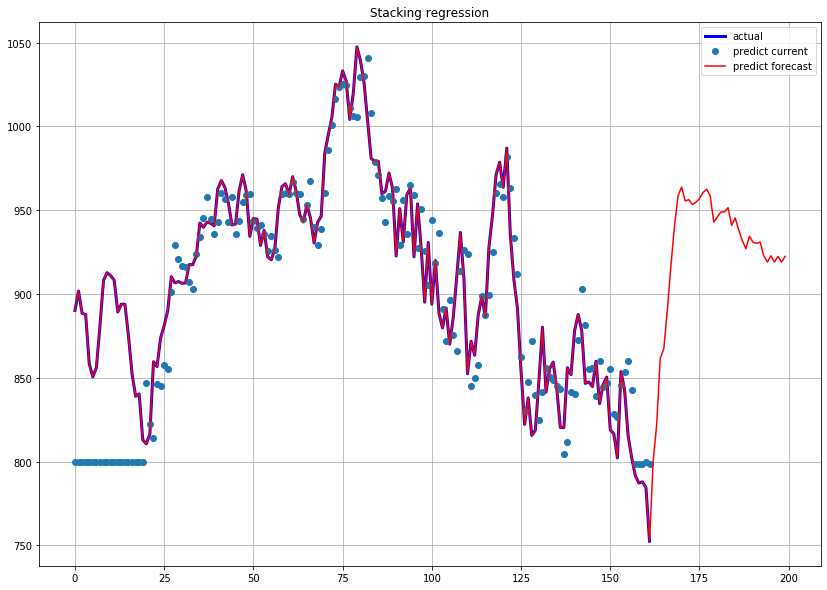

In [305]:
plt.figure(figsize=(14, 10))
plt.plot(p_series.tolist(), 'b',  linewidth='3', label="actual")
plt.plot(np.concatenate([[800]*20, reg.predict(x)]),  "o", label="predict current")
plt.plot(p, 'r', label="predict forecast")
plt.legend(loc="best")
plt.title("Stacking regression")
plt.grid(True)